<a href="https://colab.research.google.com/github/THEWACHER1103/analisis_crediticio/blob/main/Analisis_crediticio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introducción:

Los bancos desempeñan un papel fundamental en las economías modernas al evaluar el riesgo crediticio de los clientes y determinar el acceso al financiamiento. En este proyecto se realiza un análisis exploratorio de datos con el objetivo de predecir la probabilidad de impago de los clientes mediante la creación de un score crediticio. La variable SeriousDlqin2yrs será utilizada como variable objetivo, ya que representa la ocurrencia de un incumplimiento severo de pago en un horizonte de dos años.

# Importamos Las Librerias a Utilizar

In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# Importamos el DataSet Colocando como Index la columna Unnamed:0

In [27]:
df = pd.read_csv('cs-training.csv', index_col='Unnamed: 0')

## Column Description:

* SeriousDlqin2yrs = Persona con un retraso en el pago de 90 días o más.

* RevolvingUtilizationOfUnsecuredLines = Saldo total de tarjetas de crédito y líneas de crédito personales, excepto bienes inmuebles y deudas sin cuotas, como préstamos para automóviles, dividido por la suma de los límites de crédito.

* age = Edad del prestatario en años.

* NumberOfTime30-59DaysPastDueNotWorse = Número de veces que el prestatario ha tenido un retraso de 30 a 59 días sin agravarse en los últimos 2 años.

* DebtRatio =  Pagos mensuales de la deuda, pensión alimenticia y gastos de manutención divididos entre los ingresos brutos mensuales.

* MonthlyIncome = Ingresos mensuales.

* NumberOfOpenCreditLinesAndLoans = Número de préstamos abiertos (a plazos, como préstamos para automóviles o hipotecas) y líneas de crédito (por ejemplo, tarjetas de crédito).

* NumberOfTimes90DaysLate = Número de veces que el prestatario ha tenido un retraso de 90 días o más.

* NumberRealEstateLoansOrLines = Número de hipotecas y préstamos inmobiliarios, incluidas las líneas de crédito con garantía hipotecaria.

* NumberOfTime60-89DaysPastDueNotWorse = Número de veces que el prestatario ha tenido un retraso de 60 a 89 días, pero sin empeorar en los últimos dos años.

* NumberOfDependents = Número de personas a cargo en la familia, excluyéndose a sí mismo (cónyuge, hijos, etc.).

## Observaciones Iniciales:

* Existen valores nulos en dos variables importantes MonthlyIncome, NumberOfDependents.
* DataSet de 150,000 rows y 11 columnas, de las cuales solo analizaremos 10.

In [28]:
df.shape

(150000, 11)

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 150000 entries, 1 to 150000
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146076 non-null  float64
dtypes: fl

## Iniciando EDA

In [30]:
def describe_modif(df):
    num_df = df.select_dtypes(include='number')
    desc = num_df.describe()
    desc.loc['count ceros'] = (num_df == 0).sum()
    desc.loc['count negativos'] = (num_df < 0).sum()
    desc.loc['count null'] = num_df.isna().sum()
    desc.loc['pct ceros'] = (num_df == 0).mean()
    desc.loc['pct negativos'] = (num_df < 0).mean()
    desc.loc['pct nulls'] = num_df.isna().mean()
    desc.loc['Coef. Variacion'] = desc.loc['std'] / desc.loc['mean']
    q1 = desc.loc['25%']
    q3 = desc.loc['75%']
    iqr = q3 - q1
    desc.loc['IQR'] = iqr
    outliers = ((num_df < (q1 - 1.5 * iqr))|(num_df > (q3 + 1.5 * iqr))).sum()
    desc.loc['Conteo de Outliers'] = outliers
    desc.loc['Asimetria'] = num_df.skew()
    percentiles = [0, 0.25,0.50,0.60, 0.80, 0.90,0.92, 0.94, 0.95, 0.96,0.97, 0.98, 0.99,1]
    for p in percentiles:
        desc.loc[f'P{int(p*100)}'] = num_df.quantile(p)
    desc = desc.drop(index=['min','25%','50%','75%', 'max'])

    return desc.round(2)


In [31]:
describe_modif(df)

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.00,150000.00,150000.00,150000.00,150000.00,120269.00,150000.00,150000.00,150000.00,150000.00,146076.00
mean,0.07,6.05,52.30,0.42,353.01,6670.22,8.45,0.27,1.02,0.24,0.76
std,0.25,249.76,14.77,4.19,2037.82,14384.67,5.15,4.17,1.13,4.16,1.12
count ceros,139974.00,10878.00,1.00,126018.00,4113.00,1634.00,1888.00,141662.00,56188.00,142396.00,86902.00
count negativos,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
count null,0.00,0.00,0.00,0.00,0.00,29731.00,0.00,0.00,0.00,0.00,3924.00
pct ceros,0.93,0.07,0.00,0.84,0.03,0.01,0.01,0.94,0.37,0.95,0.58
pct negativos,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
pct nulls,0.00,0.00,0.00,0.00,0.00,0.20,0.00,0.00,0.00,0.00,0.03
Coef. Variacion,3.74,41.29,0.28,9.96,5.77,2.16,0.61,15.68,1.11,17.29,1.47


Por sugerencia de Eric F., realice una modificación a la función describe() de pandas con el objetivo de ampliar el análisis estadístico más allá de las métricas predeterminadas. A continuación, se presenta el detalle de los principales hallazgos por variable.


### SeriousDlqin2yrs
- La variable objetivo cuenta con **150,000 observaciones**, presentando una **tasa de incumplimiento del 6.68%**, lo que confirma un fuerte **desbalance de clases**.
- Al tratarse de una variable binaria, la desviación estándar de **0.25** es consistente con eventos poco frecuentes.
- El **coeficiente de variación (3.74)** y la **asimetría positiva (3.47)** indican que la variable se encuentra fuertemente sesgada hacia la clase negativa (no incumplimiento).

### RevolvingUtilizationOfUnsecuredLines
- La variable presenta un comportamiento irregular, ya que conceptualmente debería tomar valores entre **0 y 1**.
- Se observan valores extremadamente altos, probablemente asociados a errores de captura o inconsistencias en los datos.
- La **asimetría extrema (97.63)** confirma una fuerte distorsión causada por valores atípicos, por lo que esta variable requerirá **transformación o capping** en etapas posteriores.

### Age
- Se identifica un valor mínimo de **0**, el cual representa un error, dado que la edad mínima para otorgar crédito es mayor a 18 años. No obstante, se confirma que se trata de un único outlier.
- El promedio de edad es de **52 años**, con una desviación estándar de **15 años**, lo que refleja una dispersión moderada y consistente con una población adulta.
- El **coeficiente de variación (0.28)** indica una distribución relativamente homogénea.
- El valor máximo de **109 años** resulta altamente improbable desde una perspectiva de negocio y deberá ser tratado como outlier.

### NumberOfTime30-59DaysPastDueNotWorse
- La variable presenta una dispersión extremadamente alta, con un promedio de **0.42** y una desviación estándar de **4.19**.
- El **coeficiente de variación (9.95)** indica que la media no es representativa, ya que la distribución está dominada por outliers.
- El número máximo de atrasos leves registrados es de **98**, lo cual refuerza la necesidad de tratamiento previo.
- La variable presenta una fuerte asimetría positiva.

### DebtRatio
- La capacidad de endeudamiento promedio es de **353**, con una desviación estándar de **2037.81**.
- El **coeficiente de variación (5.77)** confirma una alta dispersión influenciada por valores extremos.
- Debido a esta distorsión, la media no resulta representativa del comportamiento general de la variable.

### MonthlyIncome
- El ingreso mensual promedio es de **6,670.22**, considerando que aproximadamente el **20% de los valores son nulos**.
- La desviación estándar de **14,384.67** refleja una alta dispersión, parcialmente explicada por la presencia de valores faltantes y posibles outliers.

### NumberOfOpenCreditLinesAndLoans
- La variable no presenta valores nulos.
- El número máximo de líneas de crédito abiertas es de **58**, valor que no resulta representativo.
- El promedio es de **8.45**, con una desviación estándar de **5.15**, lo que sugiere una dispersión moderada.
- La asimetría de **1.22** indica un ligero sesgo a la derecha.
- El **coeficiente de variación (0.61)** refleja una distribución relativamente balanceada.
- Se identifican **3,980 outliers**, cantidad moderada considerando el tamaño de la muestra.
- En general, la variable presenta un comportamiento coherente desde el punto de vista de negocio.

### NumberOfTimes90DaysLate
- La variable representa el número de veces que un cliente incurrió en atrasos de **90 días o más**.
- El promedio de **0.27** no es representativo debido a la alta dispersión.
- La fuerte **asimetría (23.09)** y el **coeficiente de variación (15.08)** evidencian una distribución altamente sesgada hacia comportamientos de incumplimiento severo.

### NumberRealEstateLoansOrLines
- La variable presenta una dispersión baja, con un promedio de **1.02** y una desviación estándar de **1.13**.
- El valor máximo de **54** se considera un outlier, dado que el tercer cuartil se mantiene en valores cercanos a **2**.
- El **coeficiente de variación (1.11)** es consistente con el comportamiento observado y refleja una dispersión moderada.

### NumberOfTime60-89DaysPastDueNotWorse
- Representa el número de atrasos entre **60 y 89 días**.
- Presenta una alta dispersión, con una desviación estándar de **4.16** y un **coeficiente de variación de 17.29**.
- La asimetría de **23.33** confirma una distribución extremadamente sesgada.
- El promedio no resulta representativo del conjunto de datos.

### NumberOfDependents
- La variable presenta **3,924 valores nulos**.
- Muestra una asimetría leve, indicando un sesgo moderado.
- El alto porcentaje de valores cero podría representar hogares sin dependientes; esta hipótesis deberá validarse cruzando la variable con **Age**.


## Graficas de Distribucion por variables

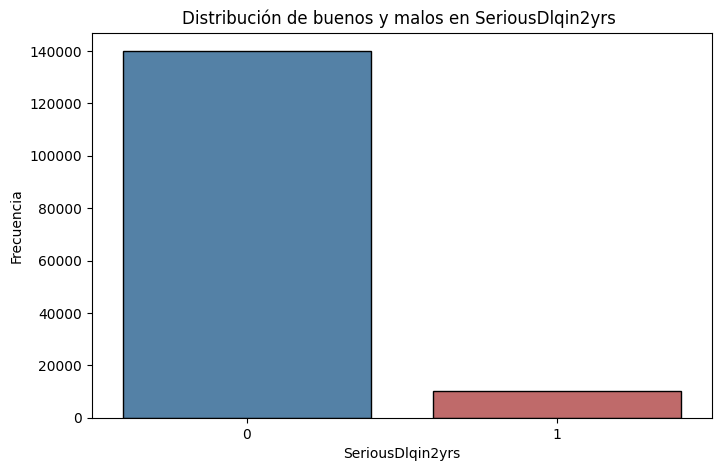

In [32]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='SeriousDlqin2yrs', hue='SeriousDlqin2yrs',
              palette={0: "steelblue", 1: "indianred"}, edgecolor='black', legend=False)
plt.title("Distribución de buenos y malos en SeriousDlqin2yrs ")
plt.xlabel('SeriousDlqin2yrs')
plt.ylabel("Frecuencia")
plt.show()

La gráfica evidencia un fuerte desbalance de clases en la variable objetivo, con una clara predominancia de clientes sin incumplimiento, lo cual deberá ser considerado en etapas posteriores del modelado.

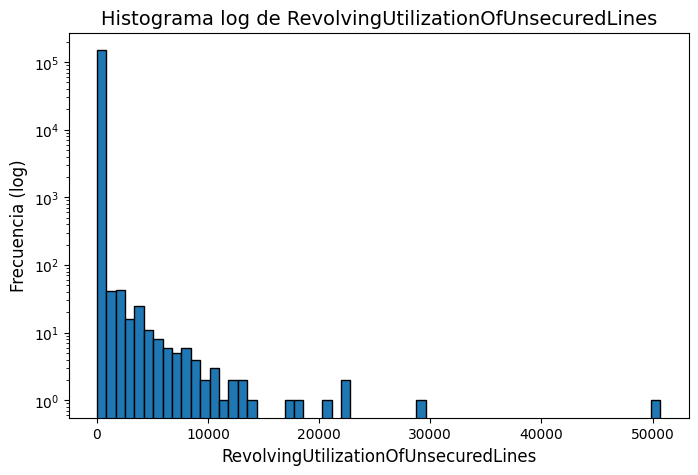

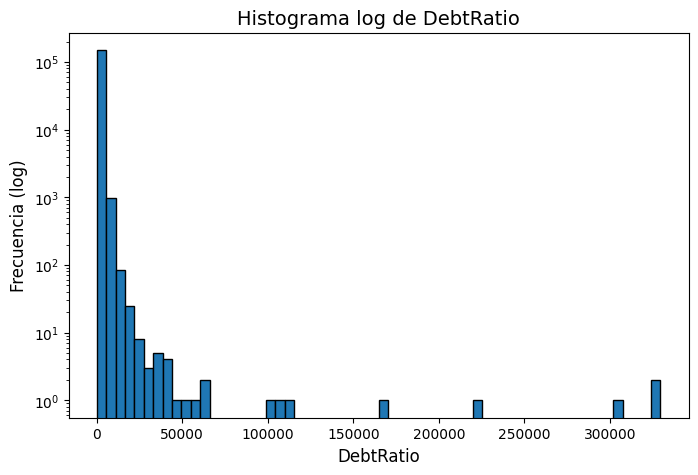

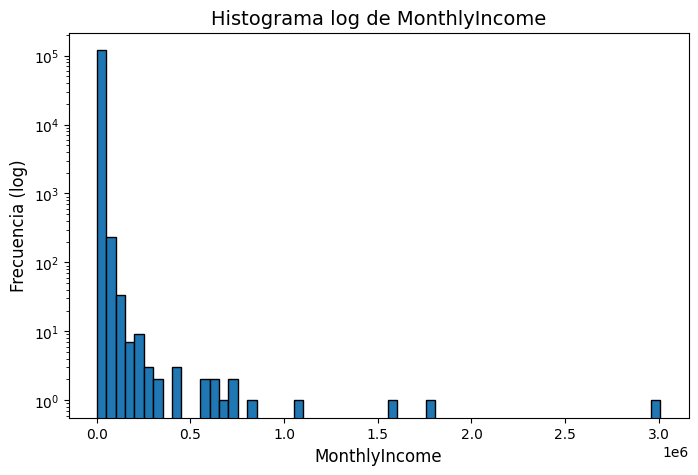

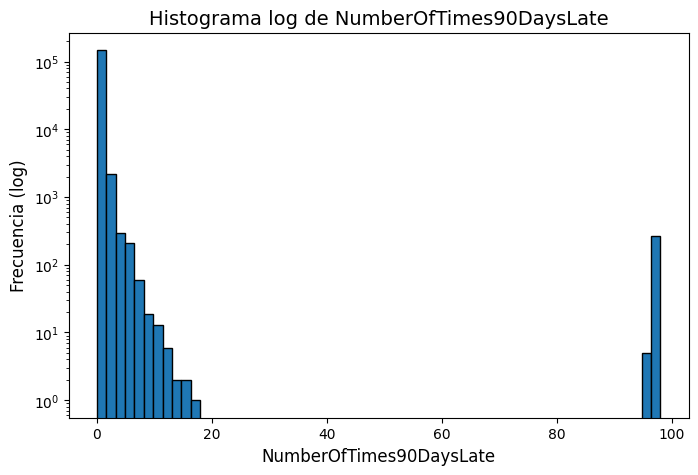

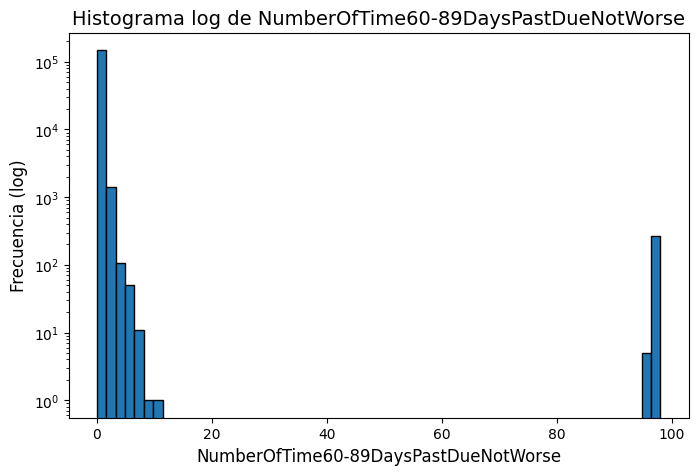

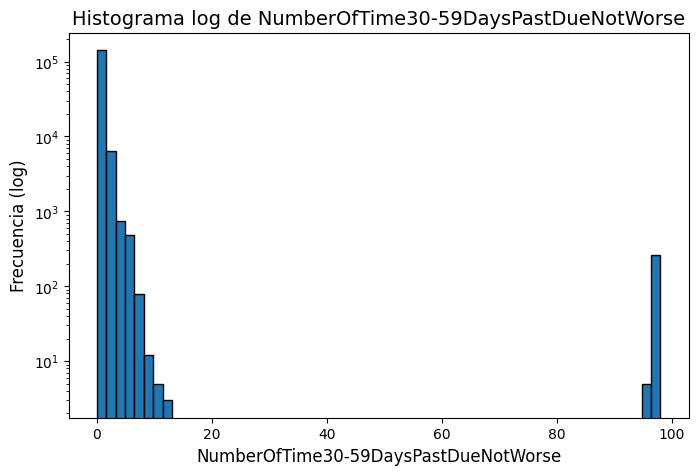

In [33]:
columns = df[[
    'RevolvingUtilizationOfUnsecuredLines',
    'DebtRatio',
    'MonthlyIncome',
    'NumberOfTimes90DaysLate',
    'NumberOfTime60-89DaysPastDueNotWorse',
    'NumberOfTime30-59DaysPastDueNotWorse',
]]
for col in columns:
    plt.figure(figsize=(8,5))
    plt.hist(df[col], bins=60, edgecolor='black')
    plt.yscale('log')
    plt.title(f"Histograma log de {col}", fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel("Frecuencia (log)", fontsize=12)
    plt.show()

### Variables con alta asimetría y presencia de valores atípicos

El análisis gráfico de las variables **RevolvingUtilizationOfUnsecuredLines**, **DebtRatio**, **MonthlyIncome** y las variables relacionadas con el historial de morosidad (**NumberOfTime30-59DaysPastDueNotWorse**, **NumberOfTime60-89DaysPastDueNotWorse** y **NumberOfTimes90DaysLate**) evidencia un patrón común caracterizado por **alta asimetría positiva**, **fuerte dispersión** y **presencia de valores extremos**.

En estas variables, la media no resulta representativa del comportamiento general de los datos, ya que las distribuciones se encuentran dominadas por outliers y concentraciones elevadas de valores cercanos a cero. En el caso particular de **MonthlyIncome**, esta situación se ve agravada por la presencia de un porcentaje significativo de valores nulos.

Dado este comportamiento, mantener estas variables en su forma original podría introducir ruido y sesgo en el modelo predictivo. Por lo tanto, en etapas posteriores se considerará la aplicación de **técnicas de tratamiento de outliers** (como capping o transformaciones) y, para las variables de morosidad, la **consolidación o transformación en características derivadas**, con el objetivo de reducir la multicolinealidad y mejorar la estabilidad del modelo.


## **Analisis de Correlaciones**

## HeatMap

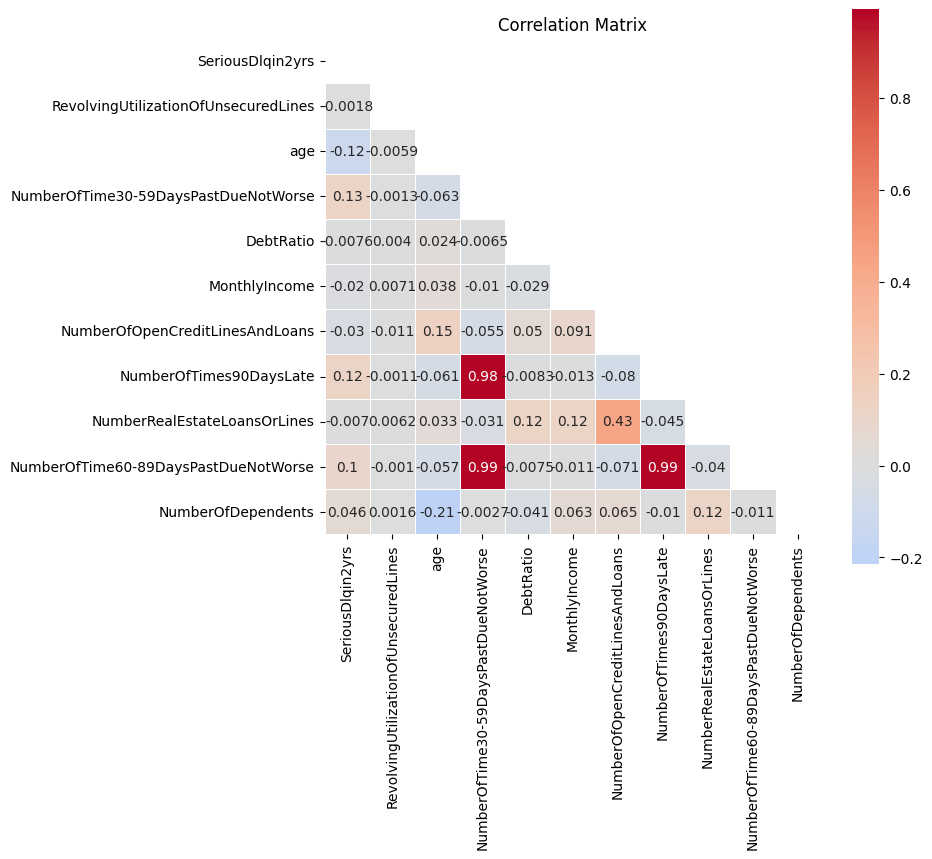

In [34]:
#Creando la Matriz de Correlacion.
corr_matrix = df.corr()

plt.figure(figsize=(8,9))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(
    data=corr_matrix,
    annot=True,
    mask=mask,
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)
plt.title('Correlation Matrix')
plt.show()

In [35]:
#sume todos los campos 3 para evitar la correlacion extrema.
df['combine_morosos'] = (df["NumberOfTimes90DaysLate"] + df["NumberOfTime60-89DaysPastDueNotWorse"]+ df["NumberOfTime30-59DaysPastDueNotWorse"])
df.loc[(df['combine_morosos']>=1), 'combine_morosos'] = 1
df['combine_morosos'].value_counts()

,count
combine_morosos,
0,119637
1,30363


Según lo conversado con Eric F., se identificamos tres variables altamente correlacionadas entre sí, todas relacionadas con distintos niveles de morosidad (30–59, 60–89 y ≥90 días). Mantener estas variables por separado podría introducir ruido y multicolinealidad en el modelo.

Tras investigar distintas alternativas de feature engineering, se decidió consolidar estas variables en una única característica binaria, que indica si el ciudadano ha presentado algún grado de morosidad en su historial crediticio.

Para ello, se sumaron las variables NumberOfTimes90DaysLate, NumberOfTime60-89DaysPastDueNotWorse y NumberOfTime30-59DaysPastDueNotWorse, y posteriormente se aplicó una transformación binaria donde:

1 representa ciudadanos con al menos un evento de morosidad

0 representa ciudadanos sin historial de morosidad

Esta transformación permitió reducir la dimensionalidad, disminuir el ruido y mejorar la interpretabilidad del modelo, alineándolo con la lógica del negocio crediticio.

## Seleccionando las Variables del Modelo.


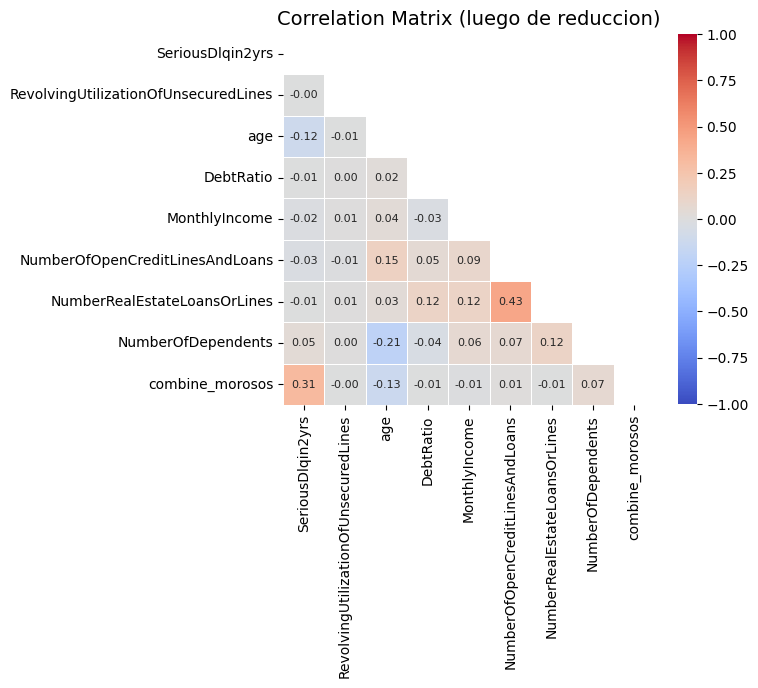

In [36]:
df_model= df[['SeriousDlqin2yrs','RevolvingUtilizationOfUnsecuredLines','age','DebtRatio','MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans','NumberRealEstateLoansOrLines',
       'NumberOfDependents','combine_morosos'
              ]]
corr_mod= df_model.corr()

plt.figure(figsize=(6,6))
mask = np.triu(np.ones_like(corr_mod, dtype=bool))
sns.heatmap(
    data=corr_mod,
    annot=True,
    fmt=".2f",
    annot_kws={"size": 8},
    mask=mask,
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
    vmin=-1,
    vmax=1
)

plt.title('Correlation Matrix (luego de reduccion)', fontsize=14)
plt.show()

## Análisis de correlación posterior a la selección de variables

Tras seleccionar las variables que serán ingresadas al modelo, se realizó un nuevo análisis de correlación con el objetivo de validar su comportamiento conjunto y descartar problemas de multicolinealidad.

Edad y número de dependientes: se observa una correlación inversa moderada, lo que indica que a mayor edad, menor cantidad de dependientes, comportamiento coherente con la estructura demográfica esperada.

Variable objetivo (SeriousDlqin2yrs): presenta su mayor correlación con la variable Combine_morosos, lo cual confirma que el historial de morosidad es uno de los principales determinantes del riesgo de impago. Este resultado valida la decisión de incluir dicha variable en el modelo.

Resto de variables: mantienen correlaciones bajas con la variable objetivo, lo que resulta positivo, ya que aportan información complementaria sin introducir redundancia ni multicolinealidad significativa.

En conjunto, este conjunto de variables proporciona al modelo señales relevantes y diversas, permitiendo capturar tanto el comportamiento histórico de pago como factores sociodemográficos y financieros necesarios para estimar la probabilidad de impago de los ciudadanos.

## Aplicando Capping


In [37]:
features = [
    'DebtRatio',
    'RevolvingUtilizationOfUnsecuredLines',
    'MonthlyIncome',
    'NumberOfDependents',
    'NumberOfOpenCreditLinesAndLoans',

]

for col in features:
    upper_limit = df_model[col].quantile(0.99)
    df_model.loc[:, col] = df_model[col].clip(upper=upper_limit)
age_upper = df_model['age'].quantile(0.98)
df_model.loc[:, 'age'] = df_model['age'].clip(upper=age_upper)
df_model[features + ['age']].describe()

df_model.loc[df_model['age'] < 18, 'age'] = np.nan
df_model['age'].fillna(df_model['age'].mean(), inplace= True)


/tmp/ipython-input-3030184255.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_model['age'].fillna(df_model['age'].mean(), inplace= True)
/tmp/ipython-input-3030184255.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['age'].fillna(df_model['age'].mean(), inplace= True)


Aplique capping superior (percentil 99) a las variables numéricas continuas que presentaban valores extremos, con el objetivo de reducir la influencia de outliers y mejorar la estabilidad del modelo sin perder información relevante.

Se excluyeron del proceso de capping las siguientes variables:
* SeriousDlqin2yrs
* combine_morosos
* combine_credict

Estas variables fueron excluidas debido a su naturaleza binaria o categórica, por lo que el capping no resulta apropiado ni aporta valor analítico.

La variable age fue tratada de manera diferenciada, ya que presentaba valores atípicos no realistas. En este caso, se realizó una validación de rangos, corrigiendo o eliminando registros fuera de límites razonables, en lugar de aplicar capping, con el fin de preservar su interpretación demográfica y evitar distorsiones en el modelo.

## Imputacion de Missings


In [38]:
def impute_best_method(
    df_model,
    features,
    test_size=0.2,
    random_state=42
):
    df_out = df_model.copy()
    report = []

    for col in features:
        if df_out[col].isna().sum() == 0:
            continue
        clean = df_out[df_out[col].notna()]
        if len(clean) < 50:
            continue
        train, test = train_test_split(
            clean,
            test_size=test_size,
            random_state=random_state
        )

        y_true = test[col]

        test_missing = test.copy()
        test_missing[col] = np.nan

        errors = {}

        # Media
        mean_val = train[col].mean()
        errors['mean'] = np.sqrt(
            mean_squared_error(y_true, np.full(len(y_true), mean_val))
        )

        # Mediana
        median_val = train[col].median()
        errors['median'] = np.sqrt(
            mean_squared_error(y_true, np.full(len(y_true), median_val))
        )

        # Moda
        mode_val = train[col].mode()[0]
        errors['mode'] = np.sqrt(
            mean_squared_error(y_true, np.full(len(y_true), mode_val))
        )

        # Regresión Lineal
        reg_features = [f for f in features if f != col]


        X_train = train[reg_features].fillna(train[reg_features].median())
        y_train = train.loc[X_train.index, col]


        X_test = test_missing.loc[y_true.index, reg_features].dropna()
        y_test_valid = y_true.loc[X_test.index]

        if len(X_train) > 30 and len(X_test) > 10:
            reg = LinearRegression()
            reg.fit(X_train, y_train)
            preds = reg.predict(X_test)

            errors['linear_regression'] = np.sqrt(
                mean_squared_error(y_test_valid, preds)
            )
        else:
            errors['linear_regression'] = np.inf

        # mejor método
        best_method = min(errors, key=errors.get)

        # Imputación final
        if best_method == 'mean':
            df_out[col] = df_out[col].fillna(mean_val)

        elif best_method == 'median':
            df_out[col] = df_out[col].fillna(median_val)

        elif best_method == 'mode':
            df_out[col] = df_out[col].fillna(mode_val)

        else:
            reg = LinearRegression()
            reg.fit(X_train, y_train)

            missing_idx = df_out[df_out[col].isna()].index
            X_missing = df_out.loc[missing_idx, reg_features].fillna(
                df_out[reg_features].median()
            )

            df_out.loc[missing_idx, col] = reg.predict(X_missing)

        report.append({
            'variable': col,
            'best_method': best_method,
            **errors
        })

    return df_out, pd.DataFrame(report)


In [39]:
df_imputed, imputation_report = impute_best_method(
    df_model=df_model,
    features=features
)

In [40]:
for col in features:
    mask = df_model[col].isna()
    df_model.loc[mask, col] = df_imputed.loc[mask, col]
imputation_report.sort_values("best_method")

,variable,best_method,mean,median,mode,linear_regression
0,MonthlyIncome,linear_regression,4342.577943,4444.785713,4546.898064,4048.447377
1,NumberOfDependents,linear_regression,1.076230,1.307770,1.307770,1.042250


* Implemente una función personalizada que evalúa múltiples métodos de imputación para valores faltantes (Mean, Median, Mode y Linear Regression), seleccionando automáticamente aquel que minimiza el error de imputación. Este enfoque me permite realizar una imputación basada en evidencia, evitando el data leakge.

## Correlacion luego de Capping y Missing.


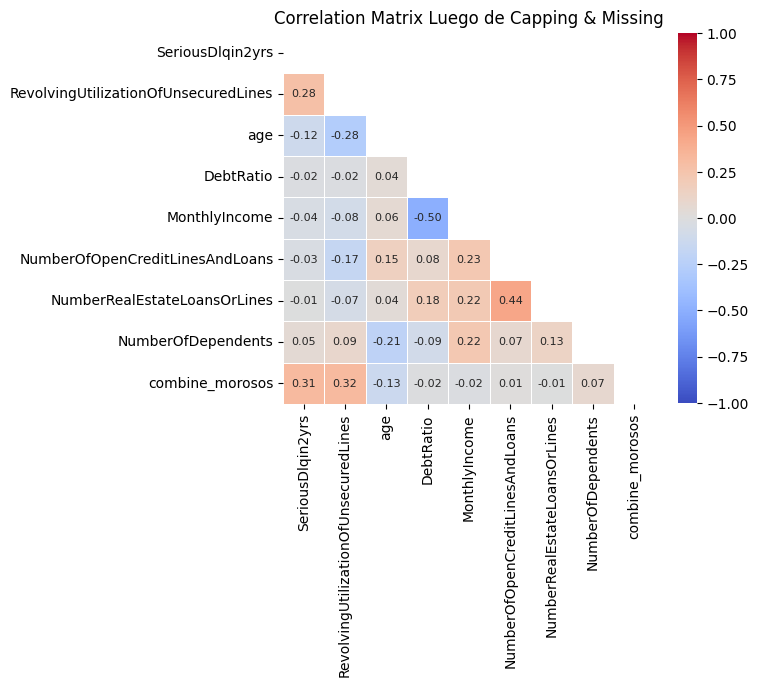

In [41]:
corr_mod= df_model.corr()
plt.figure(figsize=(6,6))
mask = np.triu(np.ones_like(corr_mod, dtype=bool))
sns.heatmap(
    data=corr_mod,
    annot=True,
    fmt=".2f",
    annot_kws={"size": 8},
    mask=mask,
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
    vmin=-1,
    vmax=1
)

plt.title('Correlation Matrix Luego de Capping & Missing', fontsize=12)
plt.show()

Luego de aplicar el tratamiento de outliers (capping) y missing, la estructura de correlaciones del dataset se vuelve más estable y económicamente coherente en comparación con la matriz original.

Observo que variables como RevolvingUtilizationOfUnsecuredLines (0.28) y combine_morosos (0.31) mantienen una correlación positiva moderada con el target, confirmando su relevancia predictiva.

El tratamiento permitió reducir el ruido generado por valores extremos, especialmente en variables financieras como MonthlyIncome y DebtRatio, donde ahora se observan relaciones más consistentes.

No se identifican problemas significativos de multicolinealidad (no hay correlaciones superiores a 0.75 entre variables independientes), por lo que no es necesario eliminar variables en esta etapa.

En conclusión, el dataset presenta una estructura estadística sólida y adecuada para avanzar al modelado predictivo.

## Modelo Predictivo

[LightGBM] [Info] Number of positive: 6016, number of negative: 83984
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002428 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1133
[LightGBM] [Info] Number of data points in the train set: 90000, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.066844 -> initscore=-2.636204
[LightGBM] [Info] Start training from score -2.636204


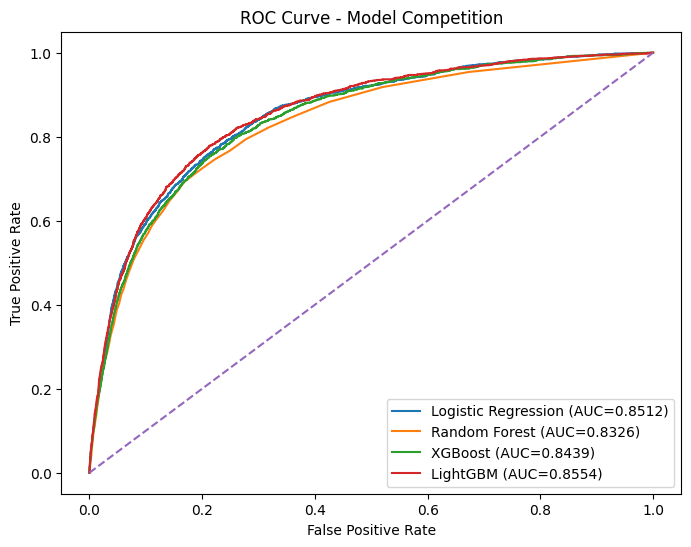


🦾 Mejor modelo: LightGBM con AUC=0.8554


In [42]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer


#Split
X = df_model.drop("SeriousDlqin2yrs", axis=1)
y = df_model["SeriousDlqin2yrs"]
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.4,
    stratify=y,
    random_state=42
)

# 20% test, 20% out_validation
X_test, X_out, y_test, y_out = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=42
)

#Modelos
r_st=555
models = {

    "Logistic Regression": Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(random_state=r_st))]),


    "Random Forest": Pipeline([
        ("model", RandomForestClassifier(random_state=r_st))]),

    "XGBoost": XGBClassifier(random_state=r_st),

    "LightGBM": LGBMClassifier(random_state=r_st)
}


#Función KS
def calculate_ks(y_true, y_probs):
    fpr, tpr, thresholds = roc_curve(y_true, y_probs)
    ks = max(tpr - fpr)
    return ks

 #Entrenamiento + Evaluación
results = []
best_auc = 0
best_model = None
best_model_name = None

plt.figure(figsize=(8,6))

for name, model in models.items():

    model.fit(X_train, y_train)

    y_train_probs = model.predict_proba(X_train)[:,1]
    y_test_probs = model.predict_proba(X_test)[:,1]

    auc_train = roc_auc_score(y_train, y_train_probs)
    auc_test = roc_auc_score(y_test, y_test_probs)

    diff = auc_train - auc_test
    ks_test = calculate_ks(y_test, y_test_probs)

    results.append({
        "Model": name,
        "AUC Train": auc_train,
        "AUC Test": auc_test,
        "Diff": diff,
        "KS Test": ks_test
    })

    # Curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_test_probs)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc_test:.4f})")

    if auc_test > best_auc:
        best_auc = auc_test
        best_model = model
        best_model_name = name

plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Model Competition")
plt.legend()
plt.show()

results_df = pd.DataFrame(results).sort_values("AUC Test", ascending=False)

results_df["Status"] = results_df["Diff"].apply(
    lambda x: " Overfitting" if x > 0.03
    else " Estable" if x < 0.02
    else " Aceptable"
)

results_df

print(f"\n🦾 Mejor modelo: {best_model_name} con AUC={best_auc:.4f}")


In [43]:
results_df["Status"] = results_df["Diff"].apply(
    lambda x: "Overfitting" if x > 0.03
    else "Estable" if x < 0.02
    else "Aceptable"
)

results_df


,Model,AUC Train,AUC Test,Diff,KS Test,Status
3,LightGBM,0.898386,0.855427,0.042959,0.565195,Overfitting
0,Logistic Regression,0.847313,0.851164,-0.003851,0.549000,Estable
2,XGBoost,0.927629,0.843897,0.083731,0.540686,Overfitting
1,Random Forest,0.999994,0.832646,0.167348,0.524908,Overfitting


## Seleccion del Modelo XGBoost

Tomando en cuenta que XGBoost no fue el mejor modelo en su configuracion inicial, su capacidad de regularizacion y flexibilidad  lo convierten en el candidato con mayor potencial de optimizacion. dado que el objetivo es maximizar performance bajo control de sobreajuste, prefiero trabajar con XGBoost como converse con eric y ajustar sus hiperparametros hasta encontrar el resultado deseado.

## Tuning Model XGBoost

# Primera aproximacion.

In [44]:
r_st=11
max_depth = 3
n_estimators = 800
learning_rate = 0.02
subsample = 0.8
colsample_bytree = 0.8
reg_alpha = 1
reg_lambda = 2
min_child_weight = 5


models = {
    "XGBoost": XGBClassifier(
        random_state=r_st,
        max_depth=max_depth,
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        eval_metric='logloss',
        reg_alpha = reg_alpha,
        reg_lambda = reg_lambda,
        min_child_weight = min_child_weight
    )
}

def calculate_ks(y_true, y_probs):
    fpr, tpr, thresholds = roc_curve(y_true, y_probs)
    return max(tpr - fpr)

results = []

for name, model in models.items():

    model.fit(X_train, y_train)

    y_train_probs = model.predict_proba(X_train)[:,1]
    y_test_probs = model.predict_proba(X_test)[:,1]
    y_out_probs  = model.predict_proba(X_out)[:,1]

    auc_train = roc_auc_score(y_train, y_train_probs)
    auc_test  = roc_auc_score(y_test, y_test_probs)
    auc_out   = roc_auc_score(y_out, y_out_probs)

    ks_train = calculate_ks(y_train, y_train_probs)
    ks_test  = calculate_ks(y_test, y_test_probs)
    ks_out   = calculate_ks(y_out, y_out_probs)

    diff = auc_train - auc_test

    results.append({
        "Model": name,
        "AUC Train": auc_train,
        "AUC Test": auc_test,
        "AUC Out": auc_out,
        "KS Train": ks_train,
        "KS Test": ks_test,
        "KS Out": ks_out,
        "Diff": diff
    })


    results_df = pd.DataFrame(results)
results_df

,Model,AUC Train,AUC Test,AUC Out,KS Train,KS Test,KS Out,Diff
0,XGBoost,0.864833,0.858472,0.856446,0.579965,0.569081,0.567935,0.006361


## Feature Importance

<Figure size 1000x800 with 0 Axes>

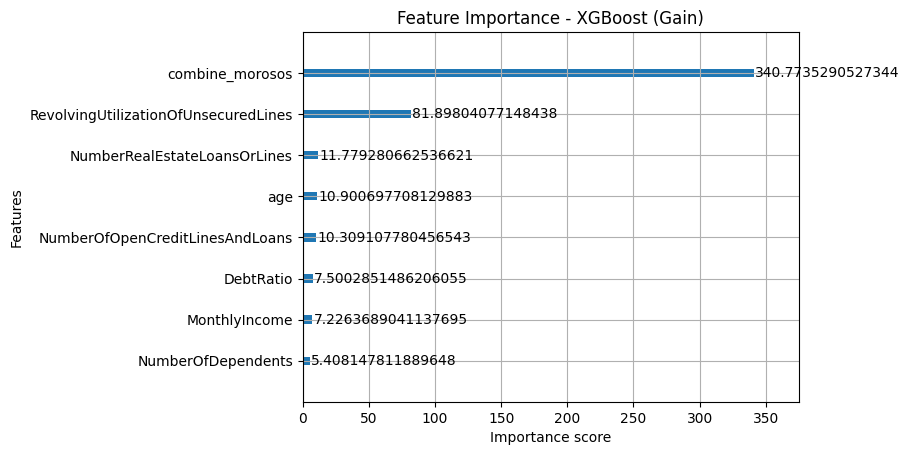

In [45]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
plot_importance(model, importance_type='gain', max_num_features=15)
plt.title("Feature Importance - XGBoost (Gain)")
plt.show()

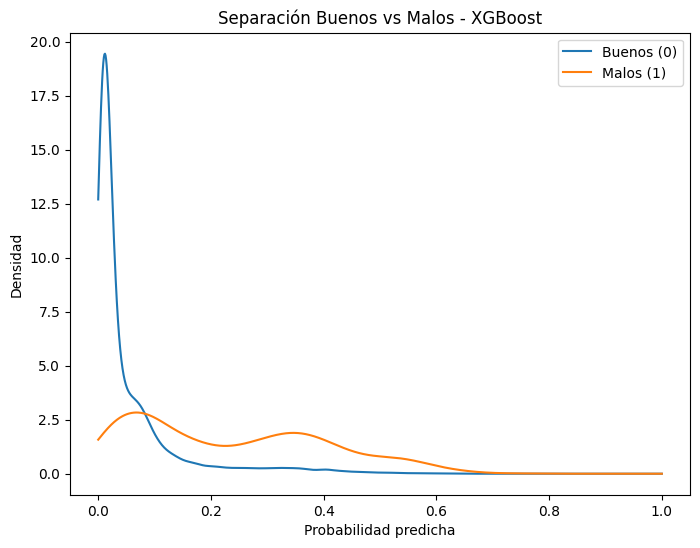

In [46]:
from scipy.stats import gaussian_kde

plt.figure(figsize=(8,6))

good = y_test_probs[y_test == 0]
bad = y_test_probs[y_test == 1]

density_good = gaussian_kde(good)
density_bad = gaussian_kde(bad)

x_vals = np.linspace(0,1,1000)

plt.plot(x_vals, density_good(x_vals), label="Buenos (0)")
plt.plot(x_vals, density_bad(x_vals), label="Malos (1)")

plt.xlabel("Probabilidad predicha")
plt.ylabel("Densidad")
plt.title("Separación Buenos vs Malos - XGBoost")
plt.legend()
plt.show()

# Segunda Aproximacion

En este caso utilizaremos optuna para optimizar los hiper parametros del modelo para validar cual da mejor resultaado.

In [47]:
pip install optuna

In [54]:
import optuna
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
import numpy as np

def objective(trial):
  params ={
      "random_state":555,
      "eval_metric":"logloss",
      "use_label_encoder":False,
      "max_depth": trial.suggest_int("max_depth", 3, 8),
      "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
      "n_estimators": trial.suggest_int("n_estimators", 300, 1200),
      "subsample": trial.suggest_float("subsample", 0.6, 1.0),
      "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
      "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
      "reg_alpha": trial.suggest_float("reg_alpha", 0, 5),
      "reg_lambda": trial.suggest_float("reg_lambda", 0, 5),
  }

  skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=555)
  auc_scores = []

  for train_idx, val_idx in skf.split(X_train, y_train):

    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    model = XGBClassifier(**params)
    model.fit(X_tr, y_tr)

    y_probs = model.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, y_probs)

    auc_scores.append(auc)
    auc_train = roc_auc_score(y_train, y_train_probs)
    auc_test  = roc_auc_score(y_test, y_test_probs)
    auc_out   = roc_auc_score(y_out, y_out_probs)

    ks_train = calculate_ks(y_train, y_train_probs)
    ks_test  = calculate_ks(y_test, y_test_probs)
    ks_out   = calculate_ks(y_out, y_out_probs)

    diff = auc_train - auc_test

    results.append({
        "Model": name,
        "AUC Train": auc_train,
        "AUC Test": auc_test,
        "AUC Out": auc_out,
        "KS Train": ks_train,
        "KS Test": ks_test,
        "KS Out": ks_out,
        "Diff": diff})

  return np.mean(auc_scores)


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=75)

print("Mejor AUC:", study.best_value)
print("Mejores hiperparametros:", study.best_params)

[I 2026-02-21 17:45:58,155] A new study created in memory with name: no-name-05b53048-c8a2-493d-a0dc-32fc8a9fd484
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:200: UserWarning: [17:45:58] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:200: UserWarning: [17:46:52] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:200: UserWarning: [17:47:05] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:200: UserWarning: [17:47:17] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are n

Mejor AUC: 0.8553344042268834
Mejores hiperparametros: {'max_depth': 3, 'learning_rate': 0.023800167630608108, 'n_estimators': 1074, 'subsample': 0.8678991637693848, 'colsample_bytree': 0.6001378308292267, 'min_child_weight': 3, 'reg_alpha': 4.853905301828473, 'reg_lambda': 4.8908774894601095}


In [55]:
print("Mejor AUC:", study.best_value)
print("Mejores hiperparametros:", study.best_params)

Mejor AUC: 0.8553344042268834
Mejores hiperparametros: {'max_depth': 3, 'learning_rate': 0.023800167630608108, 'n_estimators': 1074, 'subsample': 0.8678991637693848, 'colsample_bytree': 0.6001378308292267, 'min_child_weight': 3, 'reg_alpha': 4.853905301828473, 'reg_lambda': 4.8908774894601095}


In [60]:
best_params = study.best_params

final_model = XGBClassifier(
    **best_params,
    random_state=555,
    eval_metric="logloss",
    use_label_encoder=False)

final_model.fit(X_train, y_train)

from sklearn.metrics import roc_auc_score


y_train_probs = final_model.predict_proba(X_train)[:,1]
y_test_probs  = final_model.predict_proba(X_test)[:,1]
y_out_probs   = final_model.predict_proba(X_out)[:,1]


auc_train = roc_auc_score(y_train, y_train_probs)
auc_test  = roc_auc_score(y_test, y_test_probs)
auc_out   = roc_auc_score(y_out, y_out_probs)


ks_train = calculate_ks(y_train, y_train_probs)
ks_test  = calculate_ks(y_test, y_test_probs)
ks_out   = calculate_ks(y_out, y_out_probs)

diff = auc_train - auc_test

print("AUC Train:", auc_train)
print("AUC Test :", auc_test)
print("AUC Out  :", auc_out)

print("KS Train:", ks_train)
print("KS Test :", ks_test)
print("KS Out  :", ks_out)

print("Diff (Train - Test):", diff)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:200: UserWarning: [18:46:38] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


AUC Train: 0.865374543859418
AUC Test : 0.8577780588713962
AUC Out  : 0.8561526082988635
KS Train: 0.5794060824148876
KS Test : 0.5659020870755778
KS Out  : 0.5696611302606138
Diff (Train - Test): 0.00759648498802179
